In [1]:
!pip3.11 install map-boxes

In [15]:
import glob
import json
import os
import random
from functools import partial
from tqdm import trange
import albumentations as A
import cv2
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.retinanet import RetinaNetClassificationHead
from map_boxes import mean_average_precision_for_boxes

In [3]:
SEED = 60

def set_seed():
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
#     torch.cuda.manual_seed(SEED)
#     torch.cuda.manual_seed_all(SEED)
#     torch.backends.cudnn.deterministic = True

    os.environ['PYTHONHASHSEED'] = str(SEED)
#     os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
#     os.environ['CUDA_VISIBLE_DEVICES']= '1'

device = 'mps'

BATCH_SIZE = 4

In [4]:
train_transforms = A.Compose([
    A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0),
    A.BBoxSafeRandomCrop()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

test_transforms = A.Compose([
    A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/albumentations/core/composition.py:250: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


In [5]:
class DetectionDataset(Dataset):
    def __init__(self, img_paths, annotation_path, transforms):
        self.img_paths = img_paths
        
        with open(annotation_path, 'r') as f:
            annotation = json.load(f)
        
        self.annotation = annotation
        self.transforms = transforms
        
    def __getitem__(self, item):
        img_path = self.img_paths[item]
        img_name = os.path.basename(img_path)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
        img_labels = self.annotation[img_name]
        
        bboxes, class_labels = [], []
        for obj in img_labels:
            x, y, w, h = obj['bbox']
            bboxes.append((x, y, x + w, y + h))
            class_labels.append(obj['label'] + 1)
        
        transformed_data = self.transforms(image=img, bboxes=bboxes, class_labels=class_labels)
        transformed_image = transformed_data['image']
        transformed_bboxes = transformed_data['bboxes']
        transformed_class_labels = transformed_data['class_labels']

        return (
            torch.from_numpy(transformed_image).permute(2, 0, 1), 
            {
                'image_id': img_name,
                'boxes': torch.FloatTensor(transformed_bboxes), 
                'labels': torch.LongTensor(transformed_class_labels)
            }
        )

    
    def __len__(self):
        return len(self.img_paths)

In [6]:
id2color = {
    1: (214, 140, 69),
    2: (255, 201, 185),
    3: (144, 213, 255),
    4: (76, 149, 108),
}

def plot_bboxes(img, bboxes, class_labels):
    img = img.copy()
    for bbox, label in zip(bboxes, class_labels):
        x1, y1, x2, y2 = bbox
        img = cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), id2color[int(label)], 3)
        
    plt.imshow(img)

In [7]:
img_path = sorted(glob.glob('data/train/images/*.jpg'))[5]
img_name = os.path.basename(img_path)
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

annotation_path = 'data/train/annotations.json'

with open(annotation_path, 'r') as f:
    annotation = json.load(f)

img_labels = annotation[img_name]
        
bboxes, class_labels = [], []
for obj in img_labels:
    x, y, w, h = obj['bbox']
    bboxes.append((x, y, x + w, y + h))
    class_labels.append(obj['label'] + 1)

transformed_data = train_transforms(image=img, bboxes=bboxes, class_labels=class_labels)
transformed_image = transformed_data['image']
transformed_bboxes = transformed_data['bboxes']
transformed_class_labels = transformed_data['class_labels']

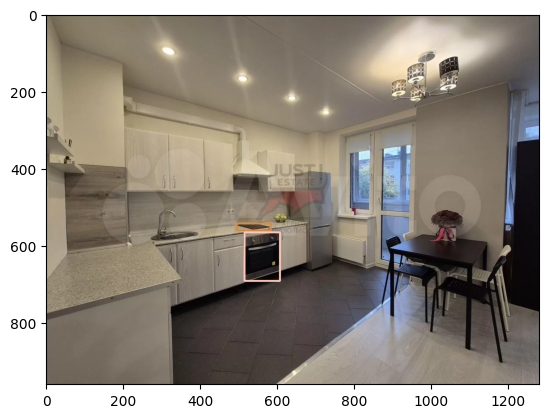

In [8]:
plot_bboxes(img, bboxes, class_labels)

In [23]:
all_train_images = sorted(glob.glob('data/train/images/*.jpg'))

train_images, valid_images = train_test_split(
    all_train_images,
    test_size=0.2,
    random_state=42
)

all_test_images = sorted(glob.glob('data/test/images/*.jpg'))

len(train_images), len(valid_images), len(all_test_images)

(95, 24, 36)

In [29]:
train_dataset = DetectionDataset(
    train_images,
    'data/train/annotations.json',
    train_transforms
)
valid_dataset = DetectionDataset(
    valid_images,
    'data/train/annotations.json',
    test_transforms
)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, BATCH_SIZE, num_workers=0, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, BATCH_SIZE, num_workers=0, shuffle=False, collate_fn=collate_fn)

print(len(train_dataset), len(valid_dataset))

95 24


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


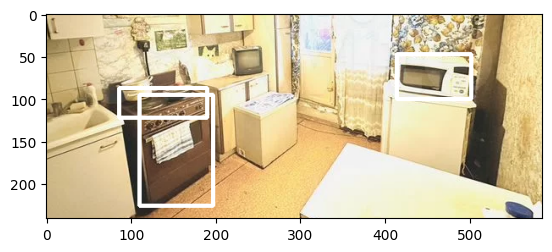

In [30]:
sample = train_dataset[6]
plot_bboxes(sample[0].permute(1, 2, 0).cpu().numpy(), sample[1]['boxes'].cpu().tolist(), sample[1]['labels'].cpu().tolist())

In [31]:
set_seed()

model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights='DEFAULT')

num_classes = 5
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(),  lr=1e-4)

In [32]:
def get_metric_format(images, targets, outputs):
    target_list, pred_list = [], []
    for image, target, output in zip(images, targets, outputs):
        c, h, w = image.shape

        image_id = target['image_id']
        labels = target['labels']
        boxes = target['boxes']
        for label, box in zip(labels, boxes):
            x_min, y_min, x_max, y_max = box
            x_min, x_max = x_min / w, x_max / w
            y_min, y_max = y_min / h, y_max / h
            target_list.append([image_id, label.item(), x_min.item(), x_max.item(), y_min.item(), y_max.item()])

        labels = output['labels']
        scores = output['scores']
        boxes = output['boxes']
        for label, score, box in zip(labels, scores, boxes):
            x_min, y_min, x_max, y_max = box
            x_min, x_max = x_min / w, x_max / w
            y_min, y_max = y_min / h, y_max / h
            pred_list.append([image_id, label.item(), score.item(), x_min.item(), x_max.item(), y_min.item(), y_max.item()])
            
    return target_list, pred_list

def average_precision(target_list, pred_list, thrs):
    ap_per_thr = []
    for thr in thrs:
        mean_ap, _ = mean_average_precision_for_boxes(target_list, pred_list, iou_threshold=thr, verbose=False)
        ap_per_thr.append(mean_ap)
    return sum(ap_per_thr) / len(ap_per_thr)

def train_epoch(loader, model, optimizer, device):
    model = model.to(device)
    model.train()
    avg_loss = 0.
    optimizer.zero_grad()
    for images, targets in loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        optimizer.zero_grad() 
        avg_loss += losses.item()
    avg_loss /= len(loader)
    return avg_loss

def valid_epoch(loader, model, device, thrs=np.linspace(0.5, 0.95, 10)):
    model = model.to(device)
    model.eval()
    targets_metric, preds_metric = [], []
    with torch.no_grad():
        for images, targets in loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
            outputs = model(images)
            target_list, pred_list = get_metric_format(images, targets, outputs)
            targets_metric.extend(target_list)
            preds_metric.extend(pred_list)
    return average_precision(targets_metric, preds_metric, thrs)

In [33]:
best_score = 0

for epoch in trange(50):
    train_loss = train_epoch(train_loader, model, optimizer, device)
    valid_score = valid_epoch(valid_loader, model, device=device)
    
    if valid_score > best_score:
        torch.save(model.state_dict(), 'best_model.pth')
        best_score = valid_score
        
    print(f'Epoch: {epoch}, train_loss: {train_loss}, valid_score: {valid_score}\n')

  0%|                                                                                                                            | 0/50 [00:06<?, ?it/s]


RuntimeError: MPS backend out of memory (MPS allocated: 8.73 GB, other allocations: 26.45 MB, max allowed: 9.07 GB). Tried to allocate 399.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))

In [ ]:
valid_epoch(valid_loader, model, device)

In [ ]:
model.eval()
with torch.no_grad():
    img = cv2.imread(valid_images[4])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    model_input = [torch.FloatTensor(img / 255).permute(2, 0, 1).to(device)]
    pred = model(model_input)

In [ ]:
plot_bboxes(img, pred[0]['boxes'].cpu().numpy(), pred[0]['labels'].cpu().numpy())

In [ ]:
crops = []
for box, label, score in zip(pred[0]['boxes'], pred[0]['labels'], pred[0]['scores']):
    x_min, y_min, x_max, y_max = box
    crops.append((img[int(y_min):int(y_max), int(x_min):int(x_max)], label.item(), score.item()))

In [ ]:
fig, axs = plt.subplots(len(crops), 1, figsize=(10, 10))

id2label = {
    1: 'плита',
    2: 'духовка',
    3: 'микроволновка',
    4: 'чайник'
}

for i, (crop, label, score) in enumerate(crops):
    axs[i].imshow(crop)
    axs[i].set_title(f'{id2label[label]}: {score}')
    axs[i].axis('off')

plt.show()
